Link Google Colab: https://colab.research.google.com/drive/1rHhl7TOxtuM4kwkAxoT5BfWROjRHETOm?usp=sharing

# Download Library

Run kode dibawah, jika selesai akan keluar prompt restart session. Setelah restart session run kode import

In [1]:
!pip uninstall -y numpy
!pip install numpy --upgrade --force-reinstall
!pip install mediapipe

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.1/62.1 kB 449.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 40.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cupy-cuda12x 13.3.0 requires numpy<2.3,>=1.22, but you have numpy 2.3.0 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.3.0 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.3.0 which is incompatible.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.6 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.3.0
    Uninstalling numpy-2.3.0:
      Successfully uninstalled numpy-2.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
grpcio-

# Import Dependency

Library yang digunakan:
  - OpenCV: Image dan video processing
  - Mediapipe: Face mesh detection dan ekstrak landmark
  - Matplotlib: Visualisasi hasil program

In [1]:
import cv2
import mediapipe as mp
import numpy as np
from google.colab import files
from PIL import Image
import io
from matplotlib import pyplot as plt

# Upload Gambar

In [7]:
uploaded = files.upload()
file_name = next(iter(uploaded))
image = cv2.imdecode(np.frombuffer(uploaded[file_name], np.uint8), cv2.IMREAD_COLOR)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

Saving foto.jpeg to foto (2).jpeg


# Inisialisasi Mediapipe Face Mesh

In [3]:
mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
    max_num_faces=1,
    refine_landmarks=True,
    static_image_mode=True,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)
mp_drawing = mp.solutions.drawing_utils

# Function Perhitungan Eye Aspect Ratio (EAR)

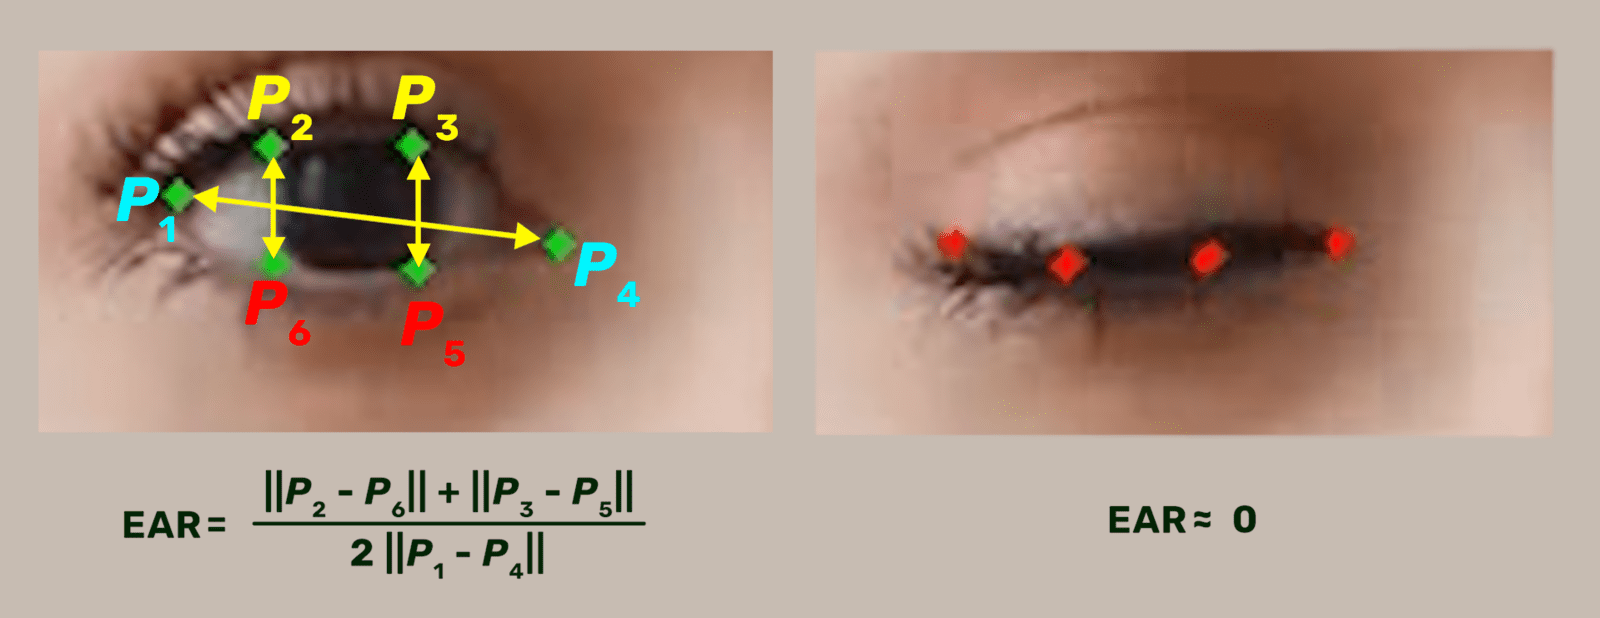

*Image Source: https://learnopencv.com/driver-drowsiness-detection-using-mediapipe-in-python/*

Seperti yang bisa dilihat di gambar atas, eye aspect ratio (EAR) dapat dihitung dengan pertama-tama mengekstrak 6 landmark mata lalu menghitung total jumlah euclidian distance landmark vertical dibagi 2 kali euclidian distance landmark horizontal.

Dalam face mesh Mediapipe 6 landmark mata berada di:
  - Landmark mata kiri = [33, 160, 158, 133, 153, 144]
  - Landmark mata kanan = [362, 385, 387, 263, 373, 380]

Untuk menentukan state mata (ditutup atau dibuka) bisa dilakukan dengan menggunakan threshold. Kebanyakan peneliti menggunakan threshold 0.2 atau 0.3 walaupun besar mata setiap orang berbeda beda (https://www.mdpi.com/2079-9292/11/19/3183). Contohnya beberapa foto salah satu anggota kelompok yang digunakan sebagai contoh di notebook ini secara konsisten menghasilkan EAR di rentang 0.18 dan 0.23 walaupun mata dibuka sehingga threshold 0.2 tidak bisa digunakan.

Karena aplikasi yang akan dibuat hanya memerlukan 2 state mata (ditutup dan dibuka), maka kami menentukan penggunaan threshold yang lebih strict yaitu 0.15

In [4]:
def eye_aspect_ratio(landmarks, eye_indices):
    p = [np.array([landmarks[i].x, landmarks[i].y]) for i in eye_indices]

    # Distance Vertical
    vertical1 = np.linalg.norm(p[1] - p[5])
    vertical2 = np.linalg.norm(p[2] - p[4])
    vertical_sum = (vertical1 + vertical2)

    # Distance Horizontal
    horizontal = np.linalg.norm(p[0] - p[3])

    # Hindari pembagian dengan 0
    if horizontal == 0:
        return 0.0

    ear = vertical_sum / (2.0 * horizontal)

    return ear

# Function untuk kebutuhan visualisasi
def eye_area(pts, img_shape):
    pts_pixel = np.array([[int(p.x * img_shape[1]), int(p.y * img_shape[0])] for p in pts], np.int32)
    return cv2.contourArea(pts_pixel), pts_pixel

# Proses Face Mesh dan Hitung EAR Dari Gambar

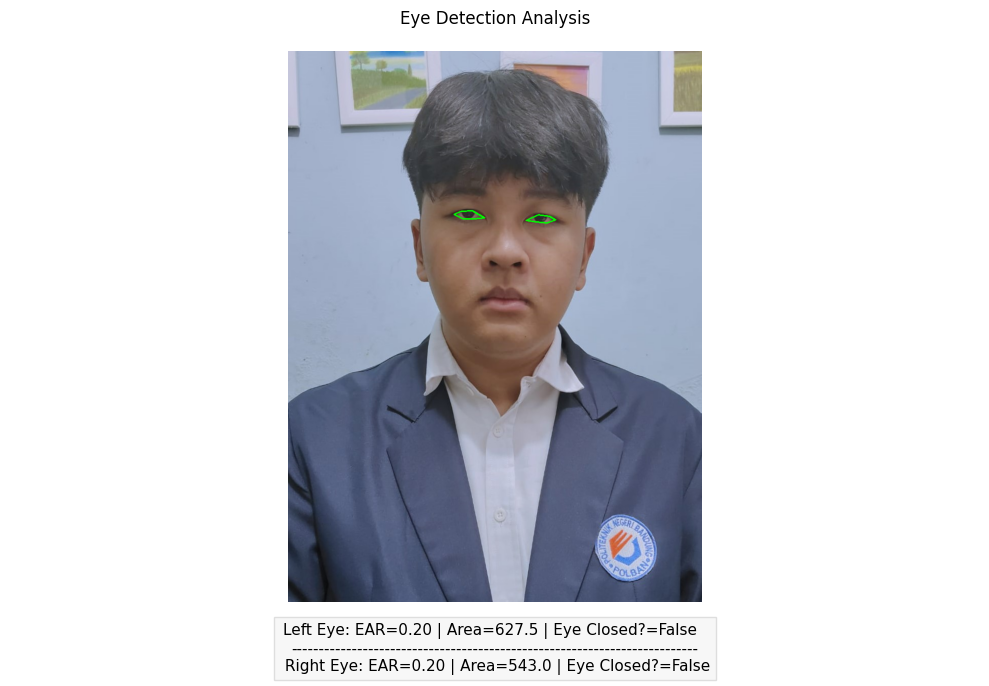

In [8]:
# Landmark mata Mediapipe
LEFT_EYE = [33, 160, 158, 133, 153, 144]
RIGHT_EYE = [362, 385, 387, 263, 373, 380]

# Threshold mata ditutup atau tidak (EAR < threshold = mata ditutup)
EAR_THRESHOLD = 0.15

results = face_mesh.process(image_rgb)
output_img = image.copy()

if results.multi_face_landmarks:
    landmarks = results.multi_face_landmarks[0].landmark

    eye_data = []

    for eye_indices, eye_name in zip([LEFT_EYE, RIGHT_EYE], ["Left", "Right"]):
        ear = eye_aspect_ratio(landmarks, eye_indices) # Hitung EAR
        area, poly = eye_area([landmarks[i] for i in eye_indices], image.shape)

        cv2.polylines(output_img, [poly], isClosed=True, color=(0, 255, 0), thickness=2)

        eye_data.append(f"{eye_name} Eye: EAR={ear:.2f} | Area={area:.1f} | Eye Closed?={ear < EAR_THRESHOLD}")

    output_rgb = cv2.cvtColor(output_img, cv2.COLOR_BGR2RGB)

    fig, (ax_img, ax_text) = plt.subplots(
        2, 1,
        gridspec_kw={'height_ratios': [10, 1]},
        figsize=(10, 7)
    )

    ax_img.imshow(output_rgb)
    ax_img.axis('off')
    ax_img.set_title("Eye Detection Analysis", pad=20)

    ax_text.axis('off')
    ax_text.text(
        0.5, 0.5,
        "  \n--------------------------------------------------------------------------\n ".join(eye_data),
        ha='center',
        va='center',
        fontsize=11,
        bbox=dict(facecolor='whitesmoke', alpha=0.7, edgecolor='lightgray')
    )

    plt.tight_layout()
    plt.show()

else:
    print("No face detected.")